# 👗 Smart Clothing Recommendation System
## YOLOv8-Pose → Body Measurements → AI Clothing Recommendations

---

### 🗺️ Pipeline Overview

```
📷 Webcam Auto-Capture  ──OR──  📁 Upload Photo
                  ↓
     🟠 YOLOv8-Pose  →  17 Body Keypoints
                  ↓
  📐 Measurement Calculator  →  Shoulder, Chest, Waist, Hip...
                  ↓
  🤖 LLM via HuggingFace  →  Sizes & Style Recommendations
```

### ✅ How to Run
| Cell | What it does |
|------|--------------|
| **Cell 1** | Install packages |
| **Cell 2** | Load YOLOv8 model *(run once)* |
| **Cell 3A** | 📷 Webcam auto-capture *(recommended)* |
| **Cell 3B** | 📁 Upload a photo *(alternative)* |
| **Cell 4** | Set your height + helpers |
| **Cell 5** | Run YOLOv8 → extract measurements |
| **Cell 6** | Add HuggingFace token |
| **Cell 7** | English recommendations |
| **Cell 8** | Try alternative LLM models |
| **Cell 9** | Arabic recommendations 🇸🇦 |
| **Cell 10** | Save & download report |

> **📌 Webcam tip:** Stand back — full body (head to feet) must be visible. Capture is automatic!

---
## 📦 Cell 1 — Install Dependencies

In [1]:
!pip install ultralytics opencv-python-headless Pillow matplotlib numpy huggingface_hub -q
print('✅ All packages installed!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.3 MB/s eta 0:00:00
✅ All packages installed!


---
## 🟠 Cell 2 — Load YOLOv8 Model
Run this once. The loaded model is shared by both the webcam and upload paths.

In [2]:
from ultralytics import YOLO
import cv2, math, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Javascript

# Options: 'yolov8n-pose.pt' (fastest)  'yolov8m-pose.pt' (balanced)  'yolov8x-pose.pt' (best)
print('⏳ Loading YOLOv8m-Pose...')
yolo = YOLO('yolov8m-pose.pt')
print('✅ Model ready!')
print()
print('👉 Now run Cell 3A (webcam) OR Cell 3B (upload) — not both.')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
⏳ Loading YOLOv8m-Pose...
✅ Model ready!

👉 Now run Cell 3A (webcam) OR Cell 3B (upload) — not both.


---
## 📷 Cell 3A — AUTO-CAPTURE via Webcam *(Recommended)*

**How it works:**
1. Your webcam opens as a small preview in the corner
2. YOLOv8 checks each frame in real-time
3. Once you are detected **stably** (3 good frames in a row), a **3-2-1 countdown** appears
4. Photo is **captured automatically** — no button needed!

> ⚠️ *Skip this cell if you prefer to upload a photo. Run Cell 3B instead.*

In [ ]:
from google.colab.output import eval_js
from base64 import b64decode

# ─────────────────────────────────────────────
#  Tuneable settings
# ─────────────────────────────────────────────
DETECT_CONF_THRESH   = 0.65   # person box confidence to start counting
KEYPOINT_CONF_THRESH = 0.40   # average keypoint confidence required
STABLE_FRAMES_NEEDED = 3      # consecutive good frames before countdown
COUNTDOWN_SECS       = 3      # countdown duration
MAX_SCAN_FRAMES      = 80     # give up after this many attempts (~80s)
# ─────────────────────────────────────────────

# ── JS helper: open webcam once, reuse stream for every call ──
OPEN_CAM_JS = """
async function openCam() {
    if (window._camReady) return 'already open';
    window._camStream = await navigator.mediaDevices.getUserMedia({video: true});
    window._camVideo  = document.createElement('video');
    window._camVideo.srcObject = window._camStream;
    window._camVideo.style = [
        'position:fixed','top:10px','right:10px','width:280px',
        'border-radius:12px','border:3px solid #FF9800','z-index:9999'
    ].join(';');
    document.body.appendChild(window._camVideo);
    await window._camVideo.play();
    await new Promise(r => setTimeout(r, 600));   // warmup
    window._camReady = true;
    return 'opened';
}
openCam()
"""

GRAB_FRAME_JS = """
async function grabFrame(overlayText) {
    const v = window._camVideo;
    const c = document.createElement('canvas');
    c.width  = v.videoWidth;
    c.height = v.videoHeight;
    const ctx = c.getContext('2d');
    ctx.drawImage(v, 0, 0);
    if (overlayText) {
        ctx.font      = 'bold 60px Arial';
        ctx.fillStyle = 'rgba(0,0,0,0.45)';
        ctx.fillRect(0, c.height/2 - 75, c.width, 95);
        ctx.fillStyle   = '#FFD700';
        ctx.textAlign   = 'center';
        ctx.textBaseline = 'middle';
        ctx.fillText(overlayText, c.width/2, c.height/2 - 28);
    }
    return c.toDataURL('image/jpeg', 0.88);
}
grabFrame(arguments[0])
"""

CLOSE_CAM_JS = """
if (window._camStream) {
    window._camStream.getTracks().forEach(t => t.stop());
    if (window._camVideo) window._camVideo.remove();
    window._camStream = null;
    window._camReady  = false;
}
"""

def b64_to_rgb(data_url):
    binary = b64decode(data_url.split(',')[1])
    nparr  = np.frombuffer(binary, np.uint8)
    bgr    = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def grab_frame(overlay=''):
    display(Javascript(GRAB_FRAME_JS.replace('arguments[0]', repr(overlay))))
    raw = eval_js(GRAB_FRAME_JS.replace('arguments[0]', repr(overlay)))
    return b64_to_rgb(raw)

# ── Step 1: Open webcam ──
print('📷 Opening webcam...')
display(Javascript(OPEN_CAM_JS))
eval_js(OPEN_CAM_JS)
print('   Webcam is live. Stand in front of it — full body visible (head to feet).')
print('   ⏳ Scanning for stable detection...\n')

# ── Step 2: Detection loop ──
consecutive_good = 0
img_rgb          = None

for attempt in range(1, MAX_SCAN_FRAMES + 1):
    frame   = grab_frame()
    results = yolo(frame, verbose=False)
    r       = results[0]

    p_conf  = 0.0
    kp_avg  = 0.0
    good    = False

    if r.boxes is not None and len(r.boxes) > 0:
        best_idx = int(np.argmax(r.boxes.conf.cpu().numpy()))
        p_conf   = float(r.boxes.conf.cpu().numpy()[best_idx])
        if p_conf >= DETECT_CONF_THRESH and r.keypoints is not None:
            kps    = r.keypoints.data.cpu().numpy()[best_idx]
            kp_avg = float(np.mean(kps[:, 2]))
            if kp_avg >= KEYPOINT_CONF_THRESH:
                good = True

    if good:
        consecutive_good += 1
        print(f'   ✅ Frame {attempt}: person={p_conf:.2f}  keypoints={kp_avg:.2f}  stable={consecutive_good}/{STABLE_FRAMES_NEEDED}')
    else:
        consecutive_good = 0
        if attempt % 6 == 0:
            print(f'   🔍 Frame {attempt}: still scanning... (person conf={p_conf:.2f})')

    if consecutive_good >= STABLE_FRAMES_NEEDED:
        print('\n🎯 Stable! Starting countdown...\n')
        break

    time.sleep(0.4)

else:
    display(Javascript(CLOSE_CAM_JS))
    print('\n⚠️  Auto-capture gave up after', MAX_SCAN_FRAMES, 'frames.')
    print('   Please run Cell 3B to upload a photo instead.')
    raise RuntimeError('Auto-capture failed — run Cell 3B.')

# ── Step 3: Countdown overlay ──
for n in range(COUNTDOWN_SECS, 0, -1):
    print(f'   📸 Capturing in {n}...')
    grab_frame(overlay=f'Hold still!   {n}...')
    time.sleep(1.0)

# ── Step 4: Final capture ──
print('   📸 Snap!')
img_rgb = grab_frame(overlay='✅  Got it!')
time.sleep(0.4)
display(Javascript(CLOSE_CAM_JS))

print(f'\n✅ Captured! Resolution: {img_rgb.shape[1]}×{img_rgb.shape[0]} px\n')
plt.figure(figsize=(5, 8))
plt.imshow(img_rgb)
plt.title('📷 Auto-Captured Photo', fontsize=13, fontweight='bold', color='#E65100')
plt.axis('off')
plt.tight_layout()
plt.show()
print('👉 Skip Cell 3B and continue from Cell 4.')

📷 Opening webcam...


<IPython.core.display.Javascript object>

MessageError: NotFoundError: Requested device not found

---
## 📁 Cell 3B — MANUAL UPLOAD *(Alternative)*

> ⚠️ **Only run this cell if you skipped Cell 3A.**  
> Running both will overwrite the image variable.

📁 Upload a full-body photo (standing straight, full body visible)...


Saving 20260210_1416251.jpg to 20260210_1416251.jpg

✅ Loaded: 20260210_1416251.jpg  |  1445×2462 px


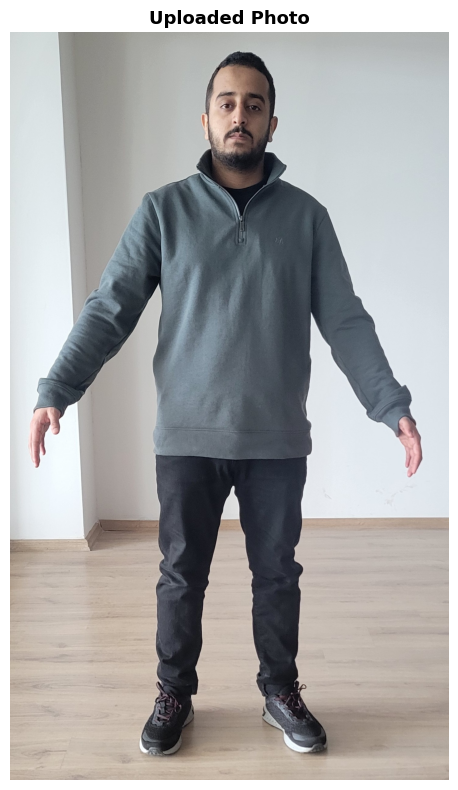

👉 Continue to Cell 4.


In [3]:
from google.colab import files

print('📁 Upload a full-body photo (standing straight, full body visible)...')
uploaded    = files.upload()
image_name  = list(uploaded.keys())[0]
nparr       = np.frombuffer(uploaded[image_name], np.uint8)
img_bgr     = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
img_rgb     = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print(f'\n✅ Loaded: {image_name}  |  {img_rgb.shape[1]}×{img_rgb.shape[0]} px')
plt.figure(figsize=(5, 8))
plt.imshow(img_rgb)
plt.title('Uploaded Photo', fontsize=13, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()
print('👉 Continue to Cell 4.')

---
## 🖼️ Cell 3C — Upload Separate Image for YOLO Segmentation

> Use this cell if you want YOLO segmentation to run on a **different (cropped/zoomed) image** instead of the full-body photo.
> The full-body image (`img_rgb`) is kept for measurements — this sets a separate `seg_img_rgb` for segmentation.

> ⚠️ **Skip this cell** if you want segmentation to run on the same image as body measurements.


🖼️  Upload a separate image to use for YOLO segmentation...
   (This can be a cropped, zoomed-in, or different angle image)
   The full-body image (img_rgb) used for measurements is UNCHANGED.



Saving 20260210_14416251.jpg to 20260210_14416251.jpg


/tmp/ipython-input-2908689470.py:24: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2908689470.py:24: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


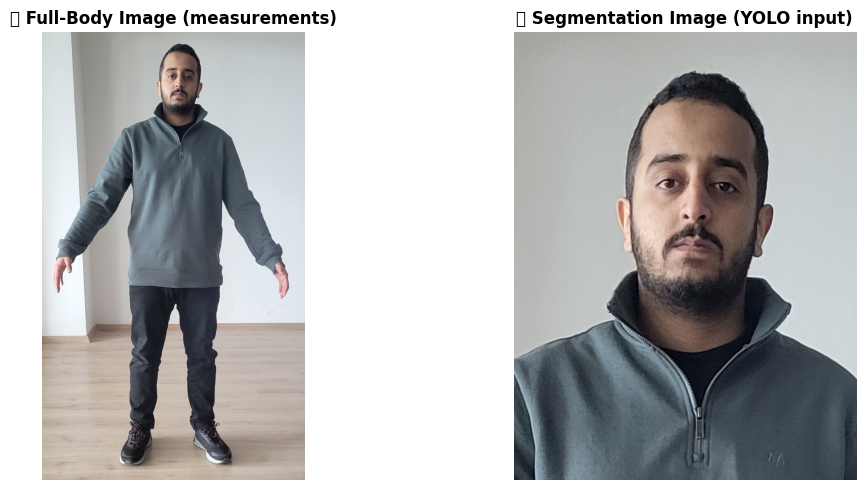

✅ Segmentation image loaded: 20260210_14416251.jpg  [552×722px]
   Full-body image (img_rgb) unchanged: [1445×2462px]

ℹ️  In Cell 5, change `yolo(img_rgb, ...)` → `yolo(seg_img_rgb, ...)` to use this image.


In [4]:
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt

print('🖼️  Upload a separate image to use for YOLO segmentation...')
print('   (This can be a cropped, zoomed-in, or different angle image)')
print('   The full-body image (img_rgb) used for measurements is UNCHANGED.\n')

seg_uploaded   = files.upload()
seg_image_name = list(seg_uploaded.keys())[0]
seg_nparr      = np.frombuffer(seg_uploaded[seg_image_name], np.uint8)
seg_img_bgr    = cv2.imdecode(seg_nparr, cv2.IMREAD_COLOR)
seg_img_rgb    = cv2.cvtColor(seg_img_bgr, cv2.COLOR_BGR2RGB)

# Preview both images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb)
axes[0].set_title('📷 Full-Body Image (measurements)', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(seg_img_rgb)
axes[1].set_title('🟠 Segmentation Image (YOLO input)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f'✅ Segmentation image loaded: {seg_image_name}  [{seg_img_rgb.shape[1]}×{seg_img_rgb.shape[0]}px]')
print(f'   Full-body image (img_rgb) unchanged: [{img_rgb.shape[1]}×{img_rgb.shape[0]}px]\n')
print('ℹ️  In Cell 5, change `yolo(img_rgb, ...)` → `yolo(seg_img_rgb, ...)` to use this image.')


---
## 📏 Cell 4 — Set Your Height & Helper Functions

In [5]:
# ===========================================================
# ✏️  ENTER YOUR HEIGHT IN CENTIMETERS
# ===========================================================
USER_HEIGHT_CM = 168  # <-- Change this!
# ===========================================================

print(f'✅ Height set to: {USER_HEIGHT_CM} cm')

def pixel_to_cm(pixel_dist, height_pixels, real_height_cm):
    if height_pixels == 0 or pixel_dist == 0:
        return 0.0
    return round((pixel_dist / height_pixels) * real_height_cm, 1)

def print_measurements(m: dict):
    print()
    print('┌─────────────────────────────────────────┐')
    print('│  📐  YOLOv8 Body Measurements             │')
    print('├──────────────────────────┬──────────────┤')
    for k, v in m.items():
        s = f'~{v:.1f} cm' if v > 0 else '❌ Not detected'
        print(f'│  {k:<24}│  {s:<11}│')
    print('└──────────────────────────┴──────────────┘')
    print()

✅ Height set to: 168 cm


---
## 🦴 Cell 5 — YOLOv8-Pose: Extract Keypoints & Calculate Measurements

✅ Detected 1 person(s). Using the most prominent.



/tmp/ipython-input-3405818933.py:14: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


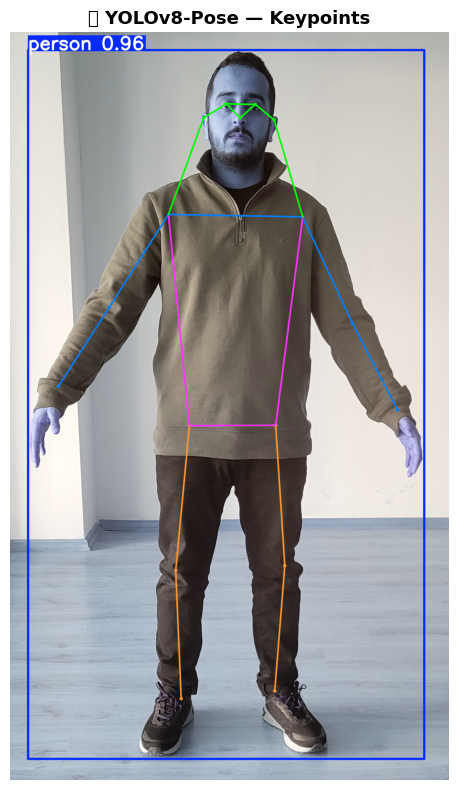


┌─────────────────────────────────────────┐
│  📐  YOLOv8 Body Measurements             │
├──────────────────────────┬──────────────┤
│  Height (reference)      │  ~168.0 cm  │
│  Shoulder Width          │  ~35.7 cm   │
│  Chest Circumf. (est.)   │  ~100.0 cm  │
│  Waist Circumf. (est.)   │  ~55.2 cm   │
│  Hip Circumf. (est.)     │  ~71.3 cm   │
│  Torso Length            │  ~55.9 cm   │
│  Arm Length              │  ~57.3 cm   │
│  Leg Length              │  ~73.0 cm   │
│  Inseam (est.)           │  ~70.9 cm   │
└──────────────────────────┴──────────────┘

ℹ️  Circumferences are estimates from front-view width ratios.


In [6]:
results = yolo(img_rgb, verbose=False)
result  = results[0]

if result.keypoints is None or len(result.keypoints.data) == 0:
    raise ValueError('❌ No person detected. Try a clearer full-body photo.')

print(f'✅ Detected {len(result.keypoints.data)} person(s). Using the most prominent.\n')

annotated = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 8))
plt.imshow(annotated)
plt.title('🟠 YOLOv8-Pose — Keypoints', fontsize=13, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# COCO-17 keypoints
kps  = result.keypoints.data.cpu().numpy()[0]
CONF = 0.3

def kp(i): return float(kps[i][0]), float(kps[i][1]), float(kps[i][2])
def dist(i, j):
    x1,y1,c1 = kp(i); x2,y2,c2 = kp(j)
    return math.hypot(x2-x1, y2-y1) if c1>=CONF and c2>=CONF else 0.0

_,nose_y,_  = kp(0)
_,ls_y,_    = kp(5)
_,rs_y,_    = kp(6)
_,la_y,la_c = kp(15)
_,ra_y,ra_c = kp(16)

head_top_y  = nose_y - abs((ls_y+rs_y)/2 - nose_y) * 0.55
ankle_avg_y = (la_y+ra_y)/2 if (la_c>CONF and ra_c>CONF) else max(la_y,ra_y)
height_px   = ankle_avg_y - head_top_y

shoulder_px = dist(5, 6)
hip_px      = dist(11, 12)
torso_px    = abs(((kp(11)[1]+kp(12)[1])/2) - ((kp(5)[1]+kp(6)[1])/2))
arm_px      = max(dist(5,7)+dist(7,9),    dist(6,8)+dist(8,10))
leg_px      = max(dist(11,13)+dist(13,15), dist(12,14)+dist(14,16))
inseam_px   = dist(11,13) + dist(13,15)

shoulder_cm = pixel_to_cm(shoulder_px, height_px, USER_HEIGHT_CM)
hip_w_cm    = pixel_to_cm(hip_px,      height_px, USER_HEIGHT_CM)
torso_cm    = pixel_to_cm(torso_px,    height_px, USER_HEIGHT_CM)
arm_cm      = pixel_to_cm(arm_px,      height_px, USER_HEIGHT_CM)
leg_cm      = pixel_to_cm(leg_px,      height_px, USER_HEIGHT_CM)
inseam_cm   = pixel_to_cm(inseam_px,   height_px, USER_HEIGHT_CM)

yolo_measurements = {
    'Height (reference)'    : float(USER_HEIGHT_CM),
    'Shoulder Width'        : shoulder_cm,
    'Chest Circumf. (est.)' : round(shoulder_cm * 2.8, 1),
    'Waist Circumf. (est.)' : round(hip_w_cm    * 2.4, 1),
    'Hip Circumf. (est.)'   : round(hip_w_cm    * 3.1, 1),
    'Torso Length'          : torso_cm,
    'Arm Length'            : arm_cm,
    'Leg Length'            : leg_cm,
    'Inseam (est.)'         : inseam_cm,
}

print_measurements(yolo_measurements)
print('ℹ️  Circumferences are estimates from front-view width ratios.')

✅ Extracted 3 skin region(s): ['Face', 'L-Wrist', 'R-Wrist']
   Skin pixels collected: 66,186
   Dominant skin RGB: (91, 71, 67)
   ITA angle: -72.6°  →  Tone: Deep | Undertone: cool/neutral


/tmp/ipython-input-524637799.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-524637799.py:193: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-524637799.py:193: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-524637799.py:193: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-524637799.py:193: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-524637799.py:193: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu 

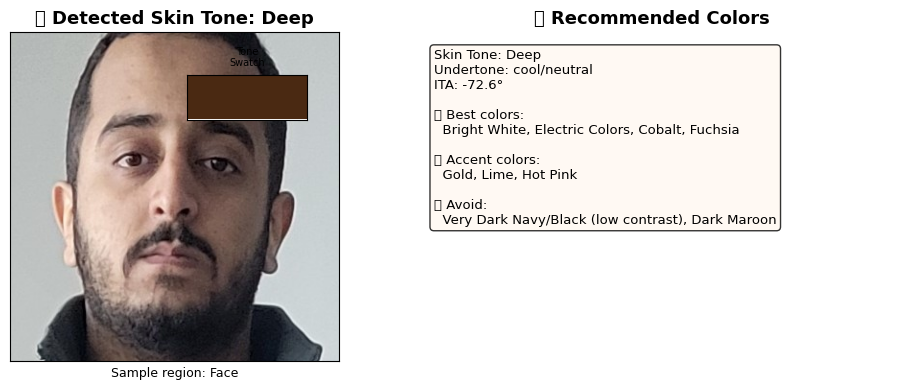


┌─────────────────────────────────────────┐
│  🎨  Skin Tone Analysis                  │
├──────────────────────────┬──────────────┤
│  Tone Category           │  Deep       │
│  Undertone               │  cool/neutral│
│  ITA Angle               │  -72.6°        │
│  Detected From           │  Face, L-Wrist, R-Wrist│
└──────────────────────────┴──────────────┘

✅ skin_tone_data ready — pass to LLM in Cell 7


In [7]:
# ===========================================================
# 🎨 Cell 5B — Skin Tone Detection & Color Recommendations
# ===========================================================
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans

# ── 1. Extract Skin Regions using YOLO Keypoints ────────────────────────────
CONF = 0.3
kps  = result.keypoints.data.cpu().numpy()[0]  # reuse from Cell 5
h, w = img_rgb.shape[:2]

def get_kp(i):
    x, y, c = kps[i]
    return int(x), int(y), float(c)

def crop_region(cx, cy, size_frac=0.06):
    """Crop a square patch around (cx, cy). size_frac is relative to image height."""
    half = int(h * size_frac)
    x1, y1 = max(0, cx - half), max(0, cy - half)
    x2, y2 = min(w, cx + half), min(h, cy + half)
    patch = img_rgb[y1:y2, x1:x2]
    return patch if patch.size > 0 else None

skin_patches = []
region_labels = []

# Face — use nose keypoint (0), expand to ~12% of height for face crop
nose_x, nose_y, nose_c = get_kp(0)
if nose_c >= CONF:
    patch = crop_region(nose_x, nose_y, size_frac=0.07)
    if patch is not None:
        skin_patches.append(patch)
        region_labels.append('Face')

# Wrists/forearms — keypoints 9 (L-wrist) and 10 (R-wrist)
for idx, label in [(9, 'L-Wrist'), (10, 'R-Wrist')]:
    kx, ky, kc = get_kp(idx)
    if kc >= CONF:
        patch = crop_region(kx, ky, size_frac=0.045)
        if patch is not None:
            skin_patches.append(patch)
            region_labels.append(label)

if not skin_patches:
    raise ValueError('❌ No keypoints with enough confidence for skin detection. '
                     'Try a clearer photo with face and hands visible.')

print(f'✅ Extracted {len(skin_patches)} skin region(s): {region_labels}')

# ── 2. HSV Skin Pixel Filtering ──────────────────────────────────────────────
def extract_skin_pixels(patch_rgb):
    """Filter pixels that fall within the HSV skin color range."""
    hsv = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2HSV)
    # Broad HSV skin range that covers fair → deep tones
    lower = np.array([0,  18, 50],  dtype=np.uint8)
    upper = np.array([25, 255, 255], dtype=np.uint8)
    mask  = cv2.inRange(hsv, lower, upper)

    # Also check a second hue range (some deeper tones wrap)
    lower2 = np.array([160, 18, 50],  dtype=np.uint8)
    upper2 = np.array([180, 255, 255], dtype=np.uint8)
    mask2  = cv2.inRange(hsv, lower2, upper2)
    mask   = cv2.bitwise_or(mask, mask2)

    skin_px = patch_rgb[mask > 0]
    return skin_px

all_skin_pixels = []
for patch in skin_patches:
    px = extract_skin_pixels(patch)
    all_skin_pixels.append(px)

all_skin_pixels = np.vstack([p for p in all_skin_pixels if len(p) > 10])
print(f'   Skin pixels collected: {len(all_skin_pixels):,}')

if len(all_skin_pixels) < 30:
    raise ValueError('❌ Too few skin pixels detected. Ensure face/hands are clearly visible.')

# ── 3. Dominant Skin Color via K-Means ───────────────────────────────────────
km = KMeans(n_clusters=3, n_init=10, random_state=42)
km.fit(all_skin_pixels)

# Pick the cluster whose centroid is most "skin-like" (highest count wins if all valid)
counts      = np.bincount(km.labels_)
dominant_px = km.cluster_centers_[np.argmax(counts)].astype(np.uint8)
dominant_rgb = tuple(dominant_px.tolist())
print(f'   Dominant skin RGB: {dominant_rgb}')

# ── 4. ITA-Based Skin Tone Classification ────────────────────────────────────
def rgb_to_ita(r, g, b):
    """
    ITA = Individual Typology Angle (degrees) — dermatological standard.
    Converts to Lab then: ITA = arctan((L*-50)/b*) × (180/π)
    """
    rgb_norm  = np.array([[[r, g, b]]], dtype=np.float32) / 255.0
    lab       = cv2.cvtColor(rgb_norm, cv2.COLOR_RGB2Lab)[0][0]
    L, _, b_  = float(lab[0]), float(lab[1]), float(lab[2])
    if b_ == 0:
        b_ = 0.001
    ita_rad   = np.arctan((L - 50) / b_)
    return float(np.degrees(ita_rad))

def classify_ita(ita):
    """Map ITA angle to Fitzpatrick-aligned category + undertone hint."""
    if   ita > 55:  return 'Fair',        'cool/neutral',  '#FDDBB4'
    elif ita > 41:  return 'Light',       'warm/neutral',  '#F5C9A0'
    elif ita > 28:  return 'Light-Medium','warm',          '#E8B48A'
    elif ita > 10:  return 'Medium',      'warm/olive',    '#C68642'
    elif ita > -30: return 'Tan/Brown',   'warm',          '#8D5524'
    else:           return 'Deep',        'cool/neutral',  '#4A2912'

ita   = rgb_to_ita(*dominant_rgb)
tone, undertone, swatch_hex = classify_ita(ita)
print(f'   ITA angle: {ita:.1f}°  →  Tone: {tone} | Undertone: {undertone}')

# ── 5. Color Palette Recommendations ─────────────────────────────────────────
# Based on color theory: seasonal palette + undertone matching
COLOR_PALETTES = {
    'Fair': {
        'best':   ['Navy Blue', 'Burgundy', 'Forest Green', 'Dusty Rose', 'Camel', 'Ivory'],
        'accent': ['Emerald', 'Cobalt Blue', 'Plum'],
        'avoid':  ['Stark White (can wash out)', 'Neon Yellow', 'Orange-Red'],
    },
    'Light': {
        'best':   ['Warm Beige', 'Terracotta', 'Olive Green', 'Coral', 'Mustard', 'Sky Blue'],
        'accent': ['Gold', 'Rust', 'Sage Green'],
        'avoid':  ['Pastel Yellow', 'Beige-on-beige (no contrast)'],
    },
    'Light-Medium': {
        'best':   ['Earth Tones', 'Burnt Orange', 'Teal', 'Warm White', 'Khaki', 'Bronze'],
        'accent': ['Turquoise', 'Amber', 'Deep Red'],
        'avoid':  ['Muddy Browns (close to skin)', 'Pale Peach'],
    },
    'Medium': {
        'best':   ['Jewel Tones', 'Cobalt', 'Fuchsia', 'Warm Red', 'Hunter Green', 'Off-White'],
        'accent': ['Gold', 'Electric Blue', 'Crimson'],
        'avoid':  ['Camel (blends in)', 'Khaki'],
    },
    'Tan/Brown': {
        'best':   ['Bright White', 'Royal Blue', 'Hot Pink', 'Yellow', 'Lime Green', 'Purple'],
        'accent': ['Metallic Gold', 'Coral', 'Tangerine'],
        'avoid':  ['Dark Brown (fades)', 'Olive Drab'],
    },
    'Deep': {
        'best':   ['Bright White', 'Electric Colors', 'Cobalt', 'Fuchsia', 'Bright Yellow', 'Red'],
        'accent': ['Gold', 'Lime', 'Hot Pink'],
        'avoid':  ['Very Dark Navy/Black (low contrast)', 'Dark Maroon'],
    },
}

palette = COLOR_PALETTES[tone]

# ── 6. Visualize ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: detected skin tone swatch + patches
ax = axes[0]
ax.set_title(f'🎨 Detected Skin Tone: {tone}', fontsize=13, fontweight='bold')

# Show detected skin patch
ax.imshow(skin_patches[0])
ax.set_xlabel(f'Sample region: {region_labels[0]}', fontsize=9)
ax.set_xticks([]); ax.set_yticks([])

# Swatch overlay in corner
swatch_rgb = tuple(int(swatch_hex[i:i+2], 16) for i in (1, 3, 5))
swatch_arr = np.full((30, 80, 3), swatch_rgb, dtype=np.uint8)
ax2 = fig.add_axes([0.27, 0.62, 0.12, 0.25])
ax2.imshow(swatch_arr)
ax2.set_title('Tone\nSwatch', fontsize=7)
ax2.set_xticks([]); ax2.set_yticks([])

# Right: color palette
ax3 = axes[1]
ax3.set_title('🌈 Recommended Colors', fontsize=13, fontweight='bold')
ax3.axis('off')

text = (
    f"Skin Tone: {tone}\n"
    f"Undertone: {undertone}\n"
    f"ITA: {ita:.1f}°\n\n"
    f"✅ Best colors:\n  " + ', '.join(palette['best'][:4]) + '\n\n'
    f"✨ Accent colors:\n  " + ', '.join(palette['accent']) + '\n\n'
    f"❌ Avoid:\n  " + ', '.join(palette['avoid'])
)
ax3.text(0.05, 0.95, text, transform=ax3.transAxes,
         verticalalignment='top', fontsize=9.5,
         bbox=dict(boxstyle='round', facecolor='#FFF8F0', alpha=0.8))

plt.tight_layout()
plt.show()

# ── 7. Store for LLM ─────────────────────────────────────────────────────────
skin_tone_data = {
    'tone'      : tone,
    'undertone' : undertone,
    'ita_angle' : round(ita, 1),
    'dominant_rgb': dominant_rgb,
    'best_colors' : palette['best'],
    'accent_colors': palette['accent'],
    'avoid_colors': palette['avoid'],
}

print()
print('┌─────────────────────────────────────────┐')
print('│  🎨  Skin Tone Analysis                  │')
print('├──────────────────────────┬──────────────┤')
print(f'│  {"Tone Category":<24}│  {tone:<11}│')
print(f'│  {"Undertone":<24}│  {undertone:<11}│')
print(f'│  {"ITA Angle":<24}│  {ita:.1f}°{"":<8}│')
print(f'│  {"Detected From":<24}│  {", ".join(region_labels):<11}│')
print('└──────────────────────────┴──────────────┘')
print()
print(f'✅ skin_tone_data ready — pass to LLM in Cell 7')